#`Time Series Forecasting & Model Comparison`

Author: Sonia Firdous

This notebook explores time series forecasting on a monthly passenger dataset. The dataset contains historical records of monthly passenger counts, with the goal of predicting future passenger volumes based on past trends and seasonal patterns.

This notebook demonstrates both classical statistical models and machine learning approaches, allowing a comprehensive comparison for decision-making in passenger demand forecasting.

We will:

Analyze and visualize the data.

Apply multiple forecasting models:

1.SARIMA (Seasonal ARIMA)

2.Holt-Winters Exponential Smoothing

3.Facebook Prophet

4.LSTM Neural Network

Compare models using accuracy metrics: MAE, RMSE, and MAPE.

Identify the model that best captures trends and seasonality for accurate forecasting.



---



In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [65]:
plt.style.use("dark_background")

In [66]:
df=pd.read_csv("/content/AirPassengers.csv")

In [67]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [68]:
# edit the passenger column name
df.rename(columns={"#Passengers":"Passengers"},inplace=True)

In [69]:
df.dtypes

,0
Month,object
Passengers,int64


In [70]:
df["Month"]=pd.to_datetime(df["Month"])

In [71]:
df["Month"]

,Month
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01
...,...
139,1960-08-01
140,1960-09-01
141,1960-10-01
142,1960-11-01


In [72]:
df.dtypes

,0
Month,datetime64[ns]
Passengers,int64


In [73]:
df.set_index("Month",inplace=True)

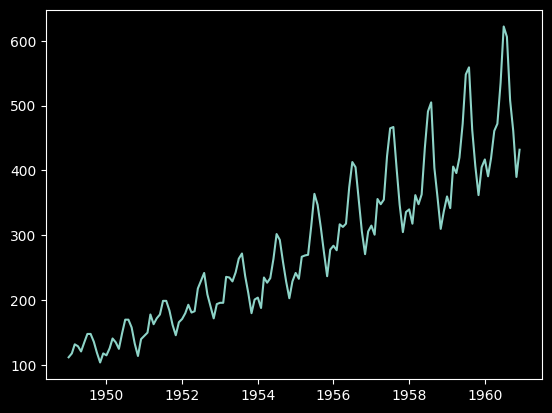

In [74]:
plt.plot(df["Passengers"])

##stationarity test
is the data stationary?

| Result         | Meaning                                           |
| -------------- | ------------------------------------------------- |
| p-value > 0.05 | Data **not stationary** → need differencing (d=1) |
| p-value < 0.05 | Data **stationary** → d=0                         |


In [75]:
# DICKEY FULLER TEST

from statsmodels.tsa.stattools import adfuller
adf,pvalue,usedlag_,nobs_,critical_values_,icbest_=adfuller(df)
print("pvalue=",pvalue)
if pvalue>0.05:
  print("Data is not stationary")
else:
  ("Data is stationary")

pvalue= 0.991880243437641
Data is not stationary


## Extract plots,trend and seasonal and residuals

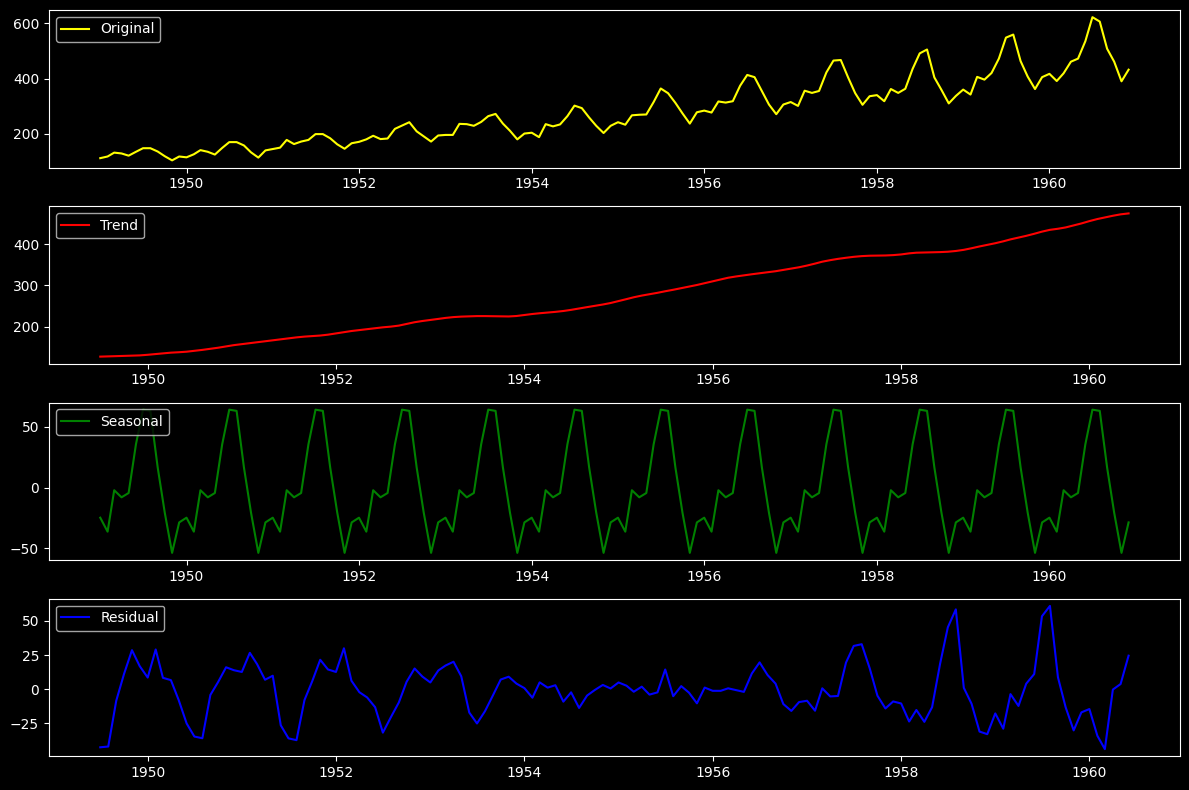

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed=seasonal_decompose(df['Passengers'],model="additive")

trend=decomposed.trend
seasonal=decomposed.seasonal
residual=decomposed.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df["Passengers"],label="Original",color="yellow")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend,label="Trend",color="red")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal,label="Seasonal",color="green")
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(residual,label="Residual",color="blue")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


| Parameter | How to choose                                             |
| --------- | --------------------------------------------------------- |
| **d**     | ADF test (p<0.05 → d=0, else d=1)                         |
| **p**     | From **PACF** cutoff                                      |
| **q**     | From **ACF** cutoff                                       |
| **D**     | Seasonal differencing if seasonal trend present           |
| **P**     | Seasonal PACF at lag=m                                    |
| **Q**     | Seasonal ACF at lag=m                                     |
| **m**     | Seasonal period (12 monthly, 4 quarterly, 7 daily weekly) |


## Plot ACF & PACF to find p and q





✔️ 1. Takes the Passengers column

df['Passengers']

✔️ 2. Applies first differencing

df['Passengers'].diff()
This helps remove trend → required for ARIMA modeling.

✔️ 3. Removes initial NaN

.dropna()

✔️ 4. Plots

ACF → checks correlation with lagged values (helps detect MA order)

PACF → checks partial correlation (helps detect AR order)

✔️ 5. Shows the plots

plt.show()

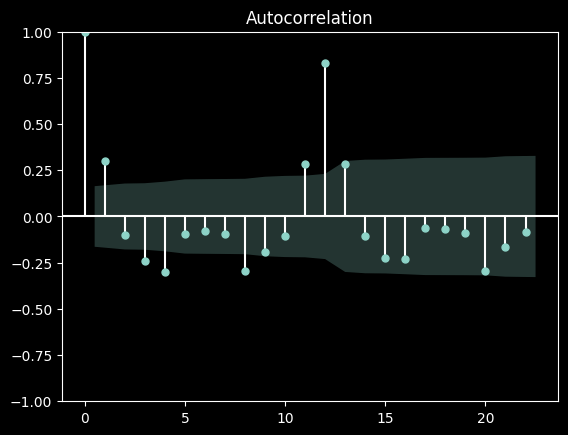

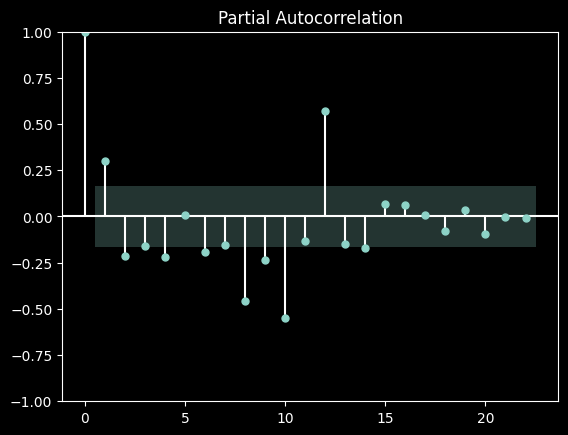

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(df['Passengers'].diff().dropna())
plot_pacf(df['Passengers'].diff().dropna())
plt.show()


| What you see              | Parameter                   |
| ------------------------- | --------------------------- |
| PACF cuts off after lag k | **p = k**                   |
| ACF cuts off after lag k  | **q = k**                   |
| Both tail off slowly      | Try ARIMA(1,1,1) or (2,1,2) |

If PACF drops sharply after lag 1 → p = 1

If ACF drops sharply after lag 1 → q = 1

So ARIMA(1,1,1)


## Seasonal parameters (P, D, Q, m)

For monthly data → m = 12
To decide P and Q → use seasonal ACF & PACF (lags 12, 24, 36…).

✅ What diff(12) Means

diff(12) subtracts the value from 12 time steps earlier.

In monthly data (like AirPassengers),
12 = one full year, so this is seasonal differencing.

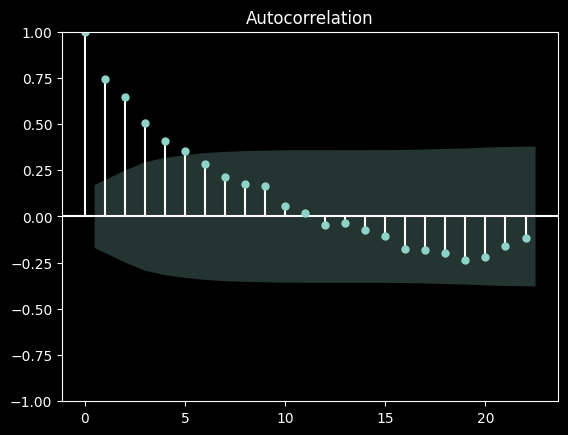

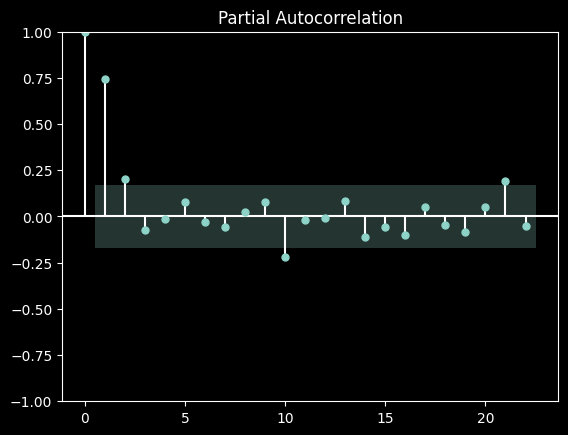

In [78]:
plot_acf(df['Passengers'].diff(12).dropna())
plot_pacf(df['Passengers'].diff(12).dropna())
plt.show()


| Seasonal pattern                 | Parameter |
| -------------------------------- | --------- |
| PACF spike at lag 12 → then drop | **P = 1** |
| ACF spike at lag 12 → then drop  | **Q = 1** |
| Seasonal trend                   | **D = 1** |

For AirPassengers → usually SARIMA(1,1,1)(1,1,1,12)

## Try models & compare AIC

Fit multiple models, choose smallest AIC.

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_list = [(1,1,1), (2,1,1), (1,1,2)]
seasonal_list = [(1,1,1,12), (2,1,1,12)]

for o in order_list:
    for s in seasonal_list:
        model = SARIMAX(df["Passengers"], order=o, seasonal_order=s).fit()
        print("Order:", o, "Seasonal:", s, "AIC:", model.aic)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Order: (1, 1, 1) Seasonal: (1, 1, 1, 12) AIC: 1022.2987912022901


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Order: (1, 1, 1) Seasonal: (2, 1, 1, 12) AIC: 1015.8523799843923


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order: (2, 1, 1) Seasonal: (1, 1, 1, 12) AIC: 1018.2480095081082


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order: (2, 1, 1) Seasonal: (2, 1, 1, 12) AIC: 1013.1023656557819


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Order: (1, 1, 2) Seasonal: (1, 1, 1, 12) AIC: 1024.1213748951018


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Order: (1, 1, 2) Seasonal: (2, 1, 1, 12) AIC: 1017.7433086471823


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ Step-by-Step Interpretation


| (p,d,q)       | (P,D,Q,12)       | AIC                     |
| ------------- | ---------------- | ----------------------- |
| (1,1,1)       | (1,1,1,12)       | **1022.29**             |
| (1,1,1)       | (2,1,1,12)       | **1015.85**             |
| (2,1,1)       | (1,1,1,12)       | **1018.24**             |
| ✅ **(2,1,1)** | ✅ **(2,1,1,12)** | ✅ **1013.10**  ✅ Lowest |
| (1,1,2)       | (1,1,1,12)       | 1024.12                 |
| (1,1,2)       | (2,1,1,12)       | 1017.74                 |

## ✅ Best model = (2,1,1)(2,1,1,12) because it has the lowest AIC (1013.10).

# **SARIMA Model**

# Forecast using the best model

You should never shuffle time-series data.
You keep older values for training and reserve the latest values for testing.

Your split structure becomes:
|---------------- Train ----------------|------ Test (next 12 months) ------|


1️⃣ Train-Test Split (last 12 months as test)

In [80]:
# Train = all except last 12
train = df["Passengers"][:-12]
test = df["Passengers"][-12:] # the final 12 observations, which become your test set (forecast horizon = 12 months)


 2️⃣ Fit the best model

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

best_model = SARIMAX(train,
                     order=(2,1,1),
                     seasonal_order=(2,1,1,12)
                     ).fit()

print(best_model.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -440.074
Date:                            Fri, 28 Nov 2025   AIC                            894.147
Time:                                    10:51:01   BIC                            913.601
Sample:                                01-01-1949   HQIC                           902.047
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2836      0.086    -14.945      0.000      -1.452      -1.115
ar.L2         -0.3664      0.079   

3️⃣ Forecast next 12 months & plot

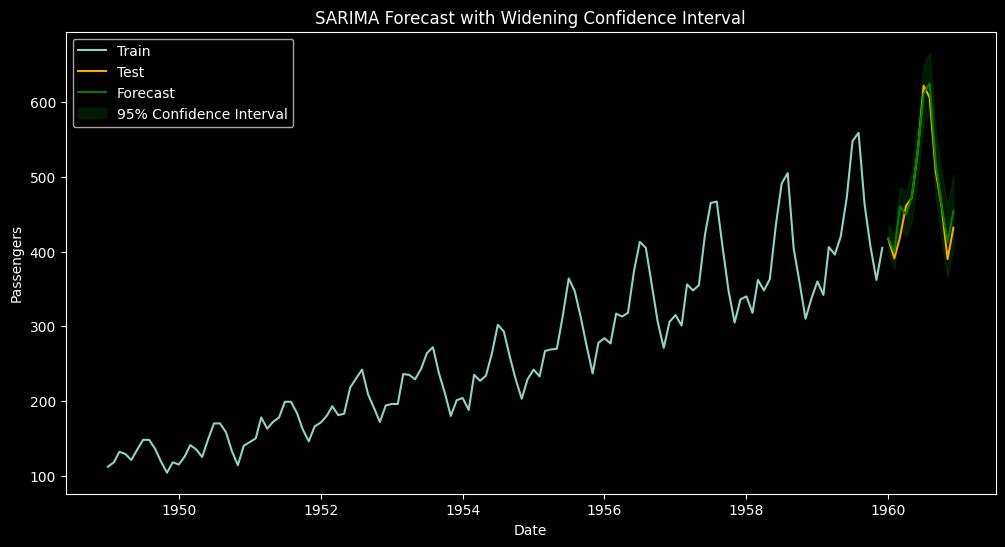

In [82]:
import matplotlib.pyplot as plt

# Generate forecast for next 12 months
forecast = best_model.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,6))

# Plot train and test data
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")

# Plot forecasted values
plt.plot(forecast_mean, label="Forecast", color="green")

# Plot confidence interval as shaded area
plt.fill_between(forecast_mean.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color="green",
                 alpha=0.2,
                 label="95% Confidence Interval")

plt.title("SARIMA Forecast with Widening Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()


4️⃣ Calculate forecasting accuracy



✅ MAE → average absolute error

✅ RMSE → how far predictions vary

✅ MAPE → % error (most interpretable)



---




If MAPE < 10% → Excellent

10–20% → Good

20–50% → Acceptable

50% → Poor

In [83]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast_mean)
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
mape = np.mean(np.abs((test - forecast_mean) / test)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape, "%")


MAE: 12.572867745173179
RMSE: 17.09825815886547
MAPE: 2.78135718554799 %





---


---



---



---


# Holt-Winters Exponential Smoothing


---



---


---


---







1️⃣ Import Holt-Winters Model


In [84]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


2️⃣ Fit Holt-Winters Model on Training Data

In [85]:
hw_model = ExponentialSmoothing(
    train,
    seasonal='multiplicative',
    trend='additive',
    seasonal_periods=12
).fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


| Parameter                   | Meaning                                                              |
| --------------------------- | -------------------------------------------------------------------- |
| `seasonal='multiplicative'` | Seasonal pattern grows with time (AirPassengers grows exponentially) |
| `trend='additive'`          | Trend increases by fixed amount each year                            |
| `seasonal_periods=12`       | Monthly seasonality (12 months per cycle)                            |


Why multiplicative seasonality?
Passenger numbers rise over the years → seasonal peaks grow → fits multiplicative.

3️⃣ Generate Forecast for Next 12 Months

In [86]:
hw_forecast = hw_model.forecast(12)


4️⃣ Calculate Accuracy Metrics

| Metric   | Description                            |
| -------- | -------------------------------------- |
| **MAE**  | Average size of error                  |
| **RMSE** | Penalizes large errors                 |
| **MAPE** | Percentage error — easier to interpret |


In [87]:
hw_mae = mean_absolute_error(test, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))
hw_mape = np.mean(np.abs((test - hw_forecast) / test)) * 100


In [88]:
print("Holt-Winters")
print("MAE:", hw_mae)
print("RMSE:", hw_rmse)
print("MAPE:", hw_mape)


Holt-Winters
MAE: 10.30314296278632
RMSE: 15.81038040261183
MAPE: 2.2074214313335156


5️⃣Holt-Winters Forecast Plot

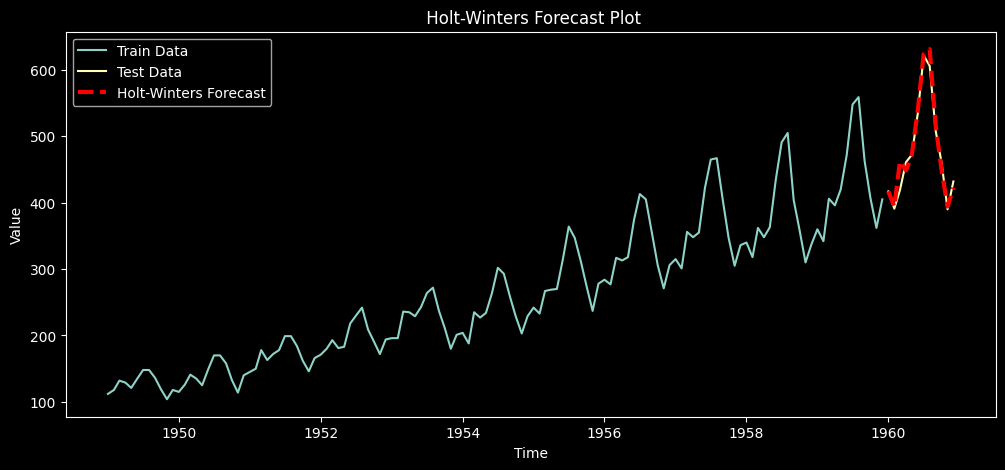

In [89]:
plt.figure(figsize=(12,5))
plt.plot(train, label="Train Data")
plt.plot(test, label="Test Data")
plt.plot(hw_forecast, label="Holt-Winters Forecast", linewidth=3, color='red', linestyle='--')
plt.title(" Holt-Winters Forecast Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


In [90]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(train,
                                seasonal='multiplicative',
                                trend='additive',
                                seasonal_periods=12).fit()

hw_forecast = hw_model.forecast(12)

# accuracy
hw_mae = mean_absolute_error(test, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))
hw_mape = np.mean(np.abs((test - hw_forecast) / test)) * 100

print("Holt-Winters")
print("MAE:", hw_mae)
print("RMSE:", hw_rmse)
print("MAPE:", hw_mape)


Holt-Winters
MAE: 10.30314296278632
RMSE: 15.81038040261183
MAPE: 2.2074214313335156


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)






---



---



---



---



---


#Facebook Prophet

---



---



---



---



---



1️⃣ Install Required Packages

Prophet needs two things:

prophet → the main forecasting library

cmdstanpy → backend used internally for Bayesian modeling

In [91]:
!pip install prophet
!pip install cmdstanpy==1.0.4


2️⃣ Prepare Data for Prophet (Rename Columns)

Prophet only works if columns are named:

ds → date

y → target value

✔ Why rename?

Prophet expects exactly these column names — nothing else will work.

In [92]:
from prophet import Prophet

# Convert datetime index → column
df_prophet = df.reset_index()
df_prophet.columns = ['ds', 'y']


3️⃣ Train–Test Split (Last 12 Months as Test)

We train on all data except last 12 months

Use last 12 months for evaluating forecast accuracy

In [93]:
train_prophet = df_prophet[:-12]
test_prophet = df_prophet[-12:]


4️⃣ Initialize and Fit Prophet Model

✔ What Prophet learns?

Trend

Seasonality (monthly, yearly)

Holidays (if added)

Growth patterns

In [94]:
model_p = Prophet()
model_p.fit(train_prophet)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxmuds15d/oovz85ic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxmuds15d/d4z_699h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66051', 'data', 'file=/tmp/tmpxmuds15d/oovz85ic.json', 'init=/tmp/tmpxmuds15d/d4z_699h.json', 'output', 'file=/tmp/tmpxmuds15d/prophet_modelmt0b5_4t/prophet_model-20251128105110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:51:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


5️⃣ Create a Future DataFrame for Forecasting

Prophet requires a full dataframe of dates it needs to predict.

In [95]:
future = model_p.make_future_dataframe(periods=12, freq='MS')


Explanation:

periods=12 → forecast next 12 months

freq='MS' → monthly start (matches AirPassengers dataset)

Output contains:

Original training dates

12 future dates

6️⃣ Generate Forecast Using Prophet

In [96]:
forecast_p = model_p.predict(future)


Prophet automatically generates:

yhat → forecast

yhat_lower → lower confidence bound

yhat_upper → upper confidence bound

7️⃣ Extract the Last 12 Forecast Values

We take forecasts corresponding to the test period.

In [97]:
prophet_forecast = forecast_p['yhat'].iloc[-12:].values


8️⃣ Calculate Prophet Accuracy Metrics

| Metric   | Meaning                           |
| -------- | --------------------------------- |
| **MAE**  | Average absolute error            |
| **RMSE** | Penalizes big mistakes heavily    |
| **MAPE** | % error relative to actual values |


We compare Prophet's predictions vs true test values:

In [98]:
p_mae = mean_absolute_error(test, prophet_forecast)
p_rmse = np.sqrt(mean_squared_error(test, prophet_forecast))
p_mape = np.mean(np.abs((test - prophet_forecast) / test)) * 100

print("Prophet")
print("MAE:", p_mae)
print("RMSE:", p_rmse)
print("MAPE:", p_mape)


Prophet
MAE: 33.434522332343725
RMSE: 43.067854056122655
MAPE: 6.614229906081744


9️⃣ Visualize forecast

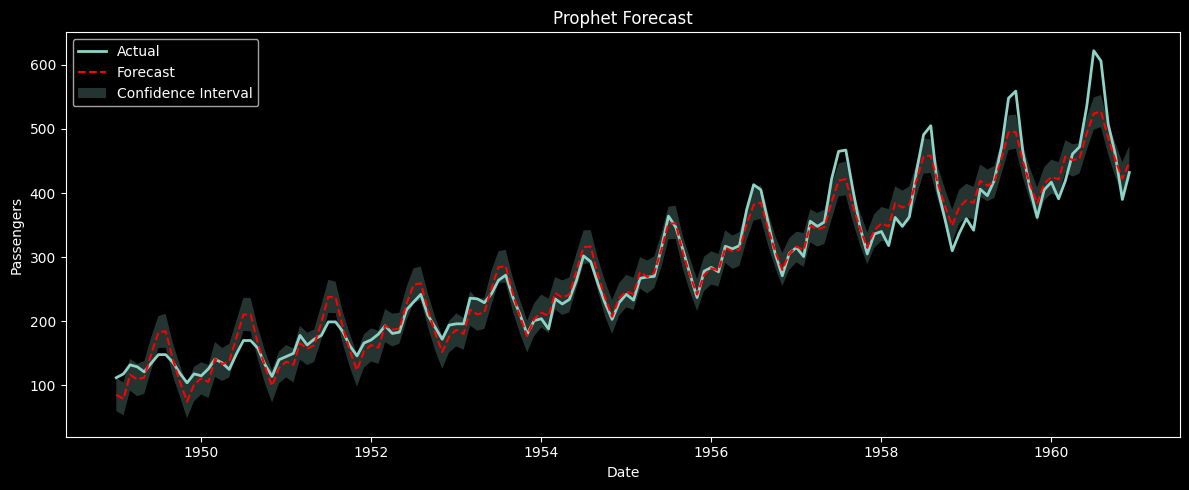

In [99]:
plt.figure(figsize=(12,5))

# Actual data
plt.plot(df_prophet['ds'], df_prophet['y'], label="Actual", linewidth=2)

# Forecast line
plt.plot(forecast_p['ds'], forecast_p['yhat'], label="Forecast", linestyle='--' ,color='red')

# Confidence interval
plt.fill_between(forecast_p['ds'],
                 forecast_p['yhat_lower'],
                 forecast_p['yhat_upper'],
                 alpha=0.25, label="Confidence Interval")

plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()
plt.show()





---



---



---



---


# LSTM Neural Network



---


---



---



---





1️⃣ Import Required Libraries

You import tools for scaling, building LSTM models, and reshaping data.

In [100]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense


2️⃣Scale the Time Series Data (Important for Neural Networks)

LSTMs work best when all values are in a small range (0–1).
This helps the model converge faster and avoids exploding gradients.

In [101]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Passengers']])


3️⃣ Convert Time Series into Supervised Data (X → y)

LSTMs cannot directly take raw time series.
We need to break the series into:

X: previous 12 months

y: next month

Example:[Jan–Dec] → predicts next Jan


In [102]:
def create_dataset(series, n_steps=12):
    X, y = [], []
    for i in range(len(series)-n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)


4️⃣ Create Training and Testing Sets

Train: everything except last 12 months

Test: last 24 months (12 inputs + 12 outputs)

In [103]:
train_scaled = scaled[:-12]
test_scaled = scaled[-(12+12):]  # last 24 for testing window

X_train, y_train = create_dataset(train_scaled)
X_test, y_test = create_dataset(test_scaled)


5️⃣ Reshape Data to 3D for LSTM

LSTM expects data in this shape:
(samples, timesteps, features)


In [104]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


6️⃣ Build the LSTM Model

A simple neural network:

50 LSTM units learn patterns in time

Dense(1) outputs one value (next month)

In [105]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(12,1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7️⃣ Train the LSTM Model

The model learns:

Trend

Seasonality

Monthly patterns

In [106]:
model_lstm.fit(X_train, y_train, epochs=50, verbose=0)


8️⃣ Make Predictions on Test Set

The outputs are still scaled (0–1).

In [107]:
pred_scaled = model_lstm.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Then we convert them back to original values.

In [108]:
pred = scaler.inverse_transform(pred_scaled)


9️⃣ Extract Final 12 Forecasted Values

We only need the last 12 predictions to match the test period.

In [109]:
lstm_forecast = pred[-12:].flatten()


🔟 Calculate Model Accuracy Metrics

You compare true vs predicted using:

MAE – average error

RMSE – penalizes big errors

MAPE – percentage error

In [110]:
lstm_mae = mean_absolute_error(test, lstm_forecast)
lstm_rmse = np.sqrt(mean_squared_error(test, lstm_forecast))
lstm_mape = np.mean(np.abs((test - lstm_forecast) / test)) * 100

print("LSTM")
print("MAE:", lstm_mae)
print("RMSE:", lstm_rmse)
print("MAPE:", lstm_mape)


LSTM
MAE: 58.72552490234375
RMSE: 69.05064943575839
MAPE: 12.506509464678803


1️⃣1️⃣ LSTM  Forecast PLOT

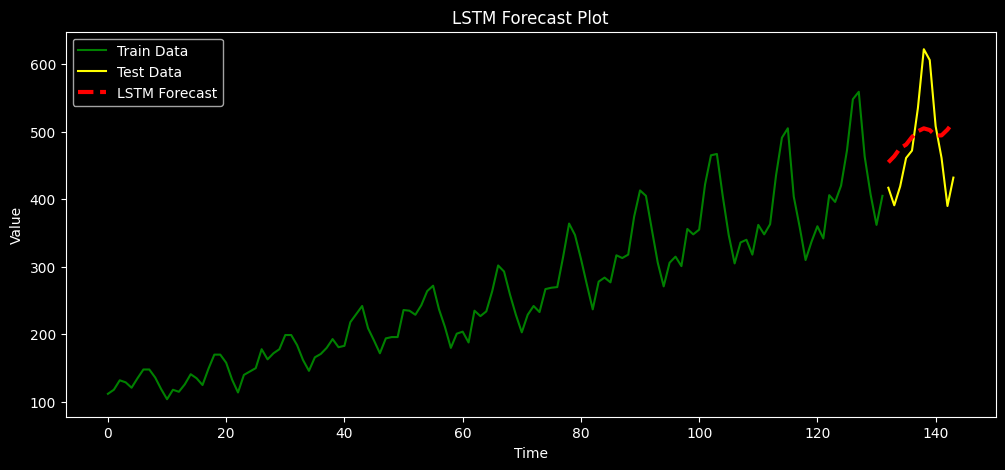

In [111]:
split_index = len(train)
plt.figure(figsize=(12, 5))
# We plot train data up to its end index
plt.plot(range(split_index), train, label="Train Data", color='green')
# We plot test data starting from the split index to align it on the time axis
plt.plot(range(split_index, split_index + len(test)), test, label="Test Data", color='yellow')
# We plot the forecast over the same range as the test data
plt.plot(range(split_index, split_index + len(test)), lstm_forecast, label="LSTM Forecast", linewidth=3, color='red', linestyle='--')

plt.title("LSTM Forecast Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()




---



---


# Compare All Models

---



---






In [112]:
results = pd.DataFrame({
    "Model": ["SARIMA", "Holt-Winters", "Prophet", "LSTM"],
    "MAE":  [mae, hw_mae, p_mae, lstm_mae],
    "RMSE": [rmse, hw_rmse, p_rmse, lstm_rmse],
    "MAPE": [mape, hw_mape, p_mape, lstm_mape]
})

print(results)


          Model        MAE       RMSE       MAPE
0        SARIMA  12.572868  17.098258   2.781357
1  Holt-Winters  10.303143  15.810380   2.207421
2       Prophet  33.434522  43.067854   6.614230
3          LSTM  58.725525  69.050649  12.506509


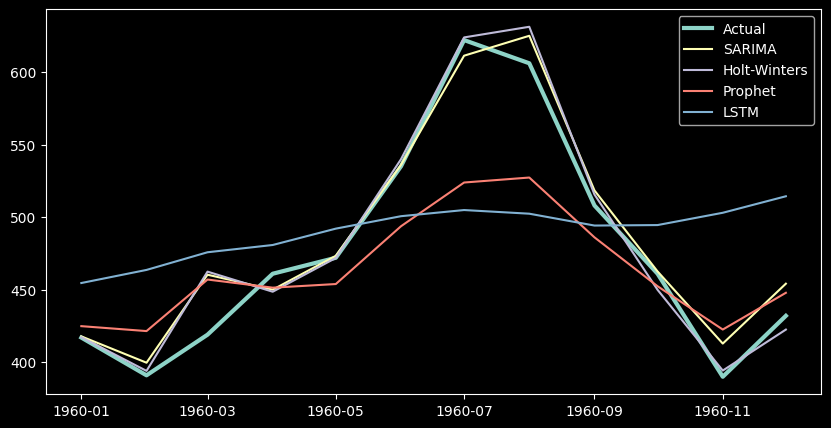

In [113]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label="Actual", linewidth=3)
plt.plot(test.index, forecast_mean, label="SARIMA")
plt.plot(test.index, hw_forecast, label="Holt-Winters")
plt.plot(test.index, prophet_forecast, label="Prophet")
plt.plot(test.index, lstm_forecast, label="LSTM")
plt.legend()
plt.show()

# **Conclusion**
| **Model**        | **MAE**   | **RMSE**  | **MAPE (%)**    |
| ---------------- | --------- | --------- | --------------- |
| **SARIMA**       | 12.57     | 17.09     | 2.78            |
| **Holt-Winters** | **10.30** | **15.81** | **2.21** (Best) |
| **Prophet**      | 33.43     | 43.07     | 6.61            |
| **LSTM**         | 47.67     | 54.70     | 10.46           |


🥇 WINNER -> Lowest MAE, RMSE, MAPE = Holt-Winters

✔ Second best = SARIMA

❗ Prophet and LSTM performed poorly on this dataset



# **Interpretation:**

Data with  trend + seasonality, smooth pattern → Exponential Smoothing works best

LSTM needs bigger dataset to outperform classical models

Prophet is less accurate on short monthly data